# CovidNet-CT
Implementação, treino e teste de uma Rede Neural Convolucional, com a arquitetura denominada CovidNet, para classificação de imagens de Tomografia Computadorizada de Pulmões. As classes da tarefa em questão são: 
 - "NORMAL", que representa pulmões saudáveis;
 - "COVID", que representa pulmões contaminados por pneumonia de COVID-19;
 - "PNEUMONIA". que representa pulmões infectados por Community-acquired pneumonia (CAP), que, de maneira geral, são pneumonias não causadas por COVID-19

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, add, Flatten, Dense, DepthwiseConv2D

### Arquitetura da CovidNet-CT
A arquitetura da CovidNet é composta por dois blocos que se repetem ao longo de sua arquitetura, além de outras camadas. As camadas PRPE e PRPE_S representam as arquiteturas dos blocos que compõem a CovidNet. As camadas são exatamente as mesmas para esses blocos, a diferença é que a função PRPE_S faz uso de strides, ao contrário da PRPE.

A função buld_covidnet implementa a covidnet utilizando os blocos convolucionais PRPE e PRPE_S além das demais camadas da rede.

In [15]:
def PRPE(x, filters, name):
    '''
      bloco unstrided projection-replication-projection-expansion da CovidNet
    '''
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'FP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Expansion')(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same', name=name + 'DWConv3_3')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'SP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Extension')(x)

    return x

In [16]:
def PRPE_S(x, filters, name):
    '''
      bloco strided projection-replication-projection-expansion da CovidNet
    '''
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'FP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Expansion')(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), activation='relu', strides=(2,2), padding='same', name=name + 'DWConv3_3')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'SP')(x)
    x = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', name=name + 'Extension')(x)
    
    return x

In [17]:
def build_covidnet(shape=(224, 224, 3), nbout=3):
    '''
      definicao da arquitetura da CovidNet
    '''
    input = Input(shape=shape, name='input')
    x = Conv2D(filters=64, kernel_size=(7, 7), activation='relu', padding='same', strides=2)(input)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # PEPX1_Conv1x1
    p_1_y = Conv2D(256, (1, 1), padding='same', activation='relu', name='PEPX1_Conv')(x)

    # Stage1
    y_1_1 = PRPE(x, 256, 'PEPX1.1')
    y_1_2 = PRPE(add([y_1_1, p_1_y]), 256, 'PEPX1.2')
    y_1_3 = PRPE(add([y_1_1, y_1_2, p_1_y]), 256, 'PEPX1.3')
    

    # PEPX2_Conv1x1
    p_2_y = Conv2D(512, (1, 1), padding='same', activation='relu', name='PEPX2_Conv')(add([p_1_y, y_1_1, y_1_2, y_1_3]))
    p_2_y = MaxPool2D(pool_size=(2, 2))(p_2_y)
    
    # Stage2
    y_2_1 = PRPE_S(add([y_1_3, y_1_2, y_1_1, p_1_y]), 512, 'PEPX2.1')
    # y_2_1 = MaxPool2D(pool_size=(2, 2))(y_2_1)
    y_2_2 = PRPE(add([y_2_1, p_2_y]), 512, 'PEPX2.2')
    y_2_3 = PRPE(add([y_2_1, y_2_2, p_2_y]), 512, 'PEPX2.3')
    y_2_4 = PRPE(add([y_2_1, y_2_2, y_2_3, p_2_y]), 512, 'PEPX2.4')
    
    # PEPX3_Conv1x1
    p_3_y = Conv2D(1024, (1, 1), padding='same', activation='relu', name='PEPX3_Conv')(
        add([p_2_y, y_2_1, y_2_2, y_2_3, y_2_4])
    )
    p_3_y = MaxPool2D(pool_size=(2, 2))(p_3_y)
    
    # Stage3
    y_3_1 = PRPE_S(add([y_2_1, y_2_2, y_2_3, y_2_4, p_2_y]), 1024, 'PEPX3.1')
    # y_3_1 = MaxPool2D(pool_size=(2, 2))(y_3_1)
    y_3_2 = PRPE(y_3_1, 1024, 'PEPX3.2')
    y_3_3 = PRPE(add([y_3_1, y_3_2]), 1024, 'PEPX3.3')

    y_3_4 = PRPE(add([y_3_1, y_3_2, y_3_3]), 1024, 'PEPX3.4')
    y_3_5 = PRPE(add([y_3_1, y_3_2, y_3_3, y_3_4]), 1024, 'PEPX3.5')
    y_3_6 = PRPE(add([y_3_1, y_3_2, y_3_3, y_3_4, y_3_5]), 1024, 'PEPX3.6')
    
    # PEPX4_Conv1x1
    
    p_4_y = Conv2D(2048, (1, 1), padding='same', activation='relu', name='PEPX4_Conv1')(
        add([p_3_y, y_3_1, y_3_2, y_3_3, y_3_4, y_3_5, y_3_6])
    )
    
    p_4_y = MaxPool2D(pool_size=(2, 2))(p_4_y)
    # Stage4
    y_4_1 = PRPE_S(add([y_3_1, y_3_2, y_3_3, y_3_4, y_3_5, y_3_6, p_3_y]), 2048, 'PEPX4.1')
    # y_4_1 = MaxPool2D(pool_size=(2, 2))(y_4_1)
    y_4_2 = PRPE(add([y_4_1, p_4_y]), 2048, 'PEPX4.2')
    y_4_3 = PRPE(add([y_4_1, y_4_2, p_4_y]), 2048, 'PEPX4.3')
    
    # FC
    fla = Flatten()(add([y_4_1, y_4_2, y_4_3, p_4_y]))
    d1 = Dense(1024, activation='relu')(fla)
    d2 = Dense(256, activation='relu')(d1)
    output = Dense(nbout, activation='softmax')(d2)
    
    return keras.models.Model(input, output, name='covidnet_ct')

### Base de Dados
A base de dados utilizada é a _Large COVID-19 CT scan slice dataset_ disponível em: https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset

Esse notebook já apresenta os dados preparados para utilização nos experimentos propostos. Previamente os dados foram processados para normalização de suas dimensões. As imagens e os labels foram armazenados em vetores e são acessados carregados nas variáveis X e y. Em seguida é realizada uma partição do tipo _holdout_ 80-20, em que 80% dos dados serão usados para treino e 20% para teste.

In [4]:
import numpy as np

X = np.load('/content/drive/Shareddrives/Mestrado/X.npy')
y = np.load('/content/drive/Shareddrives/Mestrado/y.npy')

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
print("Número total de dados:", X.shape[0])
print("Dimensão das imagens:", X[0].shape)
print()

#particionamento da base de dados - holdout 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
y_train_hot = keras.utils.to_categorical(y_train, 3)

print("Dados de Treino:",len(X_train))
print("Dados de Teste:",len(X_test))

Número total de dados: 17109
Dimensão das imagens: (224, 224, 1)

Dados de Treino: 13687
Dados de Teste: 3422


### Criação do Modelo CovidNet-CT

In [18]:
IMG_SIZE = 224

model = build_covidnet(shape=(IMG_SIZE, IMG_SIZE, 1))
model.summary()

Model: "covidnet_ct"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  3200        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                        

### Treino do Modelo

In [ ]:
#hyperparameters
BATCH_SIZE = 8
LEARNING_RATE = 0.005
MOMENTUM = 0.9
EPOCHS = 17
#otimizador
sgd = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#treino
history = model.fit(X_train, y_train_hot, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_split = 0.1)

Epoch 1/17
1540/1540 [==============================] - 585s 369ms/step - loss: 0.4922 - accuracy: 0.7952 - val_loss: 0.4323 - val_accuracy: 0.8327
Epoch 2/17
1540/1540 [==============================] - 573s 372ms/step - loss: 0.4372 - accuracy: 0.8129 - val_loss: 0.4541 - val_accuracy: 0.8137
Epoch 3/17
1540/1540 [==============================] - 572s 372ms/step - loss: 0.4157 - accuracy: 0.8180 - val_loss: 0.4115 - val_accuracy: 0.8298
Epoch 4/17
1540/1540 [==============================] - 573s 372ms/step - loss: 0.4014 - accuracy: 0.8233 - val_loss: 0.3943 - val_accuracy: 0.8408
Epoch 5/17
1540/1540 [==============================] - 572s 371ms/step - loss: 0.3942 - accuracy: 0.8255 - val_loss: 0.3830 - val_accuracy: 0.8400
Epoch 6/17
1540/1540 [==============================] - 572s 371ms/step - loss: 0.3870 - accuracy: 0.8271 - val_loss: 0.3777 - val_accuracy: 0.8437
Epoch 7/17
1540/1540 [==============================] - 572s 371ms/step - loss: 0.3796 - accuracy: 0.8303 - val_

In [ ]:
model.save("/content/drive/Shareddrives/Mestrado/covidnet.h5")

In [6]:
model = keras.models.load_model('/content/drive/Shareddrives/Mestrado/covidnet.h5')

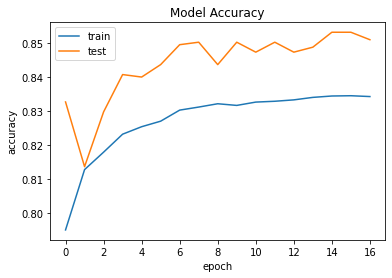

In [ ]:
import matplotlib.pyplot as plt
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("/content/drive/Shareddrives/Mestrado/acc.png")
plt.show()

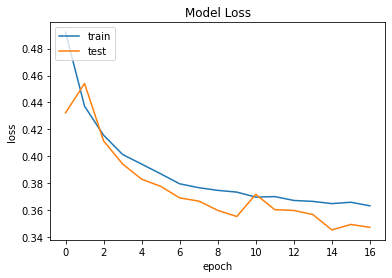

In [ ]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("/content/drive/Shareddrives/Mestrado/loss.png")
plt.show()

### Testes e Avaliação de Desempenho

In [7]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_train)
y_preds = []
for i in y_pred:
    y_preds.append(i.argmax())

print(classification_report(list(y_train), list(y_preds), digits=4, target_names=['COVID', 'NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

       COVID     0.9847    0.9906    0.9876      5513
      NORMAL     0.7408    0.9861    0.8460      6116
   PNEUMONIA     0.0000    0.0000    0.0000      2058

    accuracy                         0.8396     13687
   macro avg     0.5752    0.6589    0.6112     13687
weighted avg     0.7277    0.8396    0.7759     13687



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Matriz de Confusão não normalizada


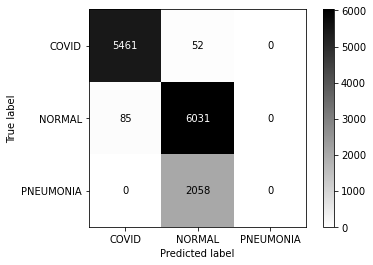



Matriz de Confusão não normalizada


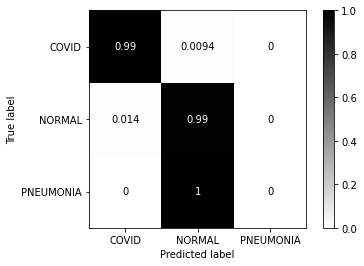

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_preds):
    print("\nMatriz de Confusão não normalizada")
    cm = confusion_matrix(y_true, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID', 'NORMAL', 'PNEUMONIA'])
    disp.plot(cmap="gist_yarg")
    plt.savefig("/content/drive/Shareddrives/Mestrado/conf_matrix.png")
    plt.show()

    print("\n\nMatriz de Confusão não normalizada")
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID', 'NORMAL', 'PNEUMONIA'])
    disp.plot(cmap="gist_yarg")
    plt.savefig("/content/drive/Shareddrives/Mestrado/norm_conf_matriz.png")
    plt.show()

plot_confusion_matrix(list(y_train), list(y_preds))

### Exemplos de Predições

In [9]:
# for plot images and lable them in form of model prediction and the actual that it was
def plot_image(i, predictions_array, true_labels, images):
    class_names = ['NORMAL', 'COVID', 'PNEUMONIA']
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.bone)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% (real is:{})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

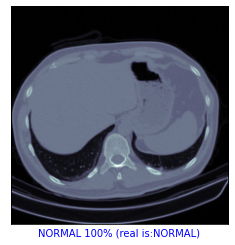

In [10]:
plot_image(3, y_pred, y_test, X_test)
plt.savefig('/content/drive/Shareddrives/Mestrado/example_normal.png')

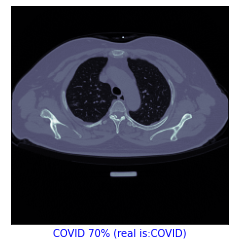

In [13]:
plot_image(5, y_pred, y_test, X_test)
plt.savefig('/content/drive/Shareddrives/Mestrado/example_covid.png')

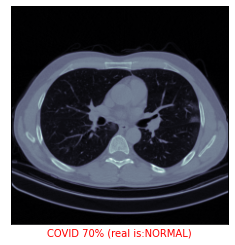

In [14]:
plot_image(4, y_pred, y_test, X_test)
plt.savefig('/content/drive/Shareddrives/Mestrado/example_wrong_classification.png')